# FIRST ITERATION: REFINE CODE AND CLEANUP LATER

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal

In [2]:
# pd.set_option("max_row", None)

In [3]:
# external imports
%run common/utilities.ipynb

# Read Data

In [4]:
raw_original = pd.read_csv("./input_data/main.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
target = "FATAL"

In [6]:
raw_original[target].value_counts()

N    595964
Y       417
Name: FATAL, dtype: int64

In [7]:
len(raw_original)

596381

In [8]:
# make original data copy
raw = raw_original.copy(deep=True)

In [9]:
raw.head()

,OBJECTID,CRIMEID,CCN,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,438194351,26872544,16034312,84628234,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
1,438194352,26872544,16034312,84833902,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
2,438194353,26872544,16034312,84938064,Driver,NaN,N,N,N,2275007,Passenger Car/automobile,N,None,N,N
3,438194354,26872544,16034312,84790164,Driver,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,N,N
4,438194355,26872544,16034312,84953497,Passenger,47.0,N,N,Y,2275008,Passenger Car/automobile,N,VA,Y,N


# Drop Identifiers

In [10]:
df_id = find_unique_identifiers(raw)

In [11]:
df_id

,OBJECTID
0,438194351
1,438194352
2,438194353
3,438194354
4,438194355
...,...
596376,438790615
596377,438790616
596378,438790617
596379,438790618


object_id is unique identifier. Drop it

In [12]:
raw = drop_unique_identifiers(raw, df_id)

In [13]:
raw.head()

,CRIMEID,CCN,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,26872544,16034312,84628234,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
1,26872544,16034312,84833902,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
2,26872544,16034312,84938064,Driver,NaN,N,N,N,2275007,Passenger Car/automobile,N,None,N,N
3,26872544,16034312,84790164,Driver,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,N,N
4,26872544,16034312,84953497,Passenger,47.0,N,N,Y,2275008,Passenger Car/automobile,N,VA,Y,N


# Drop irrelevant columns

- CRIMEID is foreign key for other dataset
- CCN is used to find location data based on parking meter coordinates
- PERSONID is unique identifier (only 10 ids are repeating, rest are unique)
- VEHICLEID is identifier

Drop these irrelevant columns

In [14]:
raw["CRIMEID"].value_counts()

25201155    66
27250936    65
26644966    59
27115668    56
23944204    54
            ..
26588602     1
26827526     1
27997092     1
27197478     1
28123904     1
Name: CRIMEID, Length: 244624, dtype: int64

In [15]:
raw["CCN"].value_counts()

14195200    66
17044398    65
10148861    59
16188154    56
12043692    54
            ..
20028982     1
17016262     1
20148125     1
20071502     1
16019739     1
Name: CCN, Length: 244669, dtype: int64

In [16]:
raw["PERSONID"].value_counts()[:20]

89467466    2
89764243    2
89514186    2
89993044    2
90219441    2
90643975    2
90135860    2
89459376    2
89550113    2
90602111    2
84918897    1
84663761    1
84671957    1
84880898    1
84657618    1
84618703    1
84661712    1
84616654    1
84622797    1
84620748    1
Name: PERSONID, dtype: int64

In [17]:
raw["VEHICLEID"].value_counts()

None       17470
1012204       59
884780        57
2761084       55
908411        53
           ...  
874917         1
4573341        1
5159356        1
5679282        1
5091277        1
Name: VEHICLEID, Length: 456075, dtype: int64

In [18]:
# https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
raw = raw.drop(["CRIMEID", "CCN", "PERSONID", "VEHICLEID"], axis=1)

In [19]:
raw.head()

,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,Passenger,31.0,N,N,N,Passenger Car/automobile,N,VA,Y,N
1,Passenger,31.0,N,N,N,Passenger Car/automobile,N,VA,Y,N
2,Driver,NaN,N,N,N,Passenger Car/automobile,N,None,N,N
3,Driver,31.0,N,N,N,Passenger Car/automobile,N,VA,N,N
4,Passenger,47.0,N,N,Y,Passenger Car/automobile,N,VA,Y,N


In [20]:
nan_checker(raw)

,var,proportion,dtype
0,AGE,0.284444,float64


# Consolidate column values 

Many column values have too many levels, thus consolidating these values.

In [21]:
raw.columns

Index(['PERSONTYPE', 'AGE', 'FATAL', 'MAJORINJURY', 'MINORINJURY',
       'INVEHICLETYPE', 'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED',
       'SPEEDING'],
      dtype='object')

In [22]:
for col in raw.columns:
    print(col)
    print(raw[col].unique())
    print()

PERSONTYPE
['Passenger' 'Driver' 'Pedestrian' 'Bicyclist']

AGE
[ 3.10e+01       nan  4.70e+01  6.30e+01  4.20e+01  2.30e+01  2.50e+01
  2.80e+01  6.80e+01  3.30e+01  3.50e+01  3.00e+01  3.60e+01  4.00e+01
  3.80e+01  5.70e+01  7.00e+00  5.20e+01  5.40e+01  2.60e+01  4.40e+01
  7.50e+01  6.00e+01  6.20e+01  3.20e+01  0.00e+00  5.10e+01  7.00e+01
  2.10e+01  2.90e+01  2.70e+01  4.90e+01  4.30e+01  4.80e+01  3.90e+01
  3.70e+01  2.40e+01  2.00e+01  5.50e+01  5.60e+01  4.50e+01  4.10e+01
  4.60e+01  8.20e+01  4.00e+00  8.00e+01  6.10e+01  5.90e+01  2.19e+02
  2.20e+01  5.00e+01  3.40e+01  5.30e+01  7.30e+01  8.30e+01  6.60e+01
  1.60e+01  1.90e+01  7.60e+01  5.80e+01  8.10e+01  6.90e+01  7.80e+01
  1.00e+00  1.10e+01  1.80e+01  6.70e+01  6.40e+01  6.50e+01  7.10e+01
  1.30e+01  7.20e+01  5.00e+00  7.40e+01  1.70e+01  6.00e+00  8.00e+00
  7.70e+01  1.19e+02  1.50e+01  1.00e+01  9.00e+00  3.00e+00  8.50e+01
  2.00e+00  1.20e+01  9.10e+01  7.90e+01  1.40e+01  9.30e+01  8.40e+01
  8.70e+01  8

### Consolidation strategy

Consolidate and retain all NaN's they will be handled in next step:

INVEHICLETYPE:
- {
 'Passenger Car/automobile': "Passenger Car",
 'Other Vehicle': "Other Vehicle",
 'None': np.NaN,
 'Passenger Van': "Passenger Car",
 'Firearms': "Other Vehicle",
 'Atv (all Terrain Vehicle)': "Other Vehicle",
 'Motor Cycle': "2 wheeler",
 'Moped/scooter': "2 wheeler",
 'Drugs/ Narcotics': "Other Vehicle",
 'Construction/industrial Equipment': "Other Vehicle",
 'Motorhome/camper/rv (recreational Vehicle)': "Other Vehicle",
 'Trailer': "Other Vehicle",
 'Farm Equipment': "Other Vehicle",
 'Watercraft/boat': "Other Vehicle",
 'Snow Mobile': "Other Vehicle",
 'Aircraft': "Other Vehicle"
}

    
LICENSEPLATESTATE:

- 50 States
    
AGE: (exclude lower limit and include upper limit)

- "0-17", "18-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90"

**INVEHICLETYPE**

In [23]:
len(raw["INVEHICLETYPE"].isna())

596381

In [24]:
raw["INVEHICLETYPE"].value_counts()

Passenger Car/automobile                      401933
Other Vehicle                                  50871
Suv (sport Utility Vehicle)                    34122
Passenger Van                                  19297
None                                           17544
Bus                                            16900
Firearms                                       14225
Pickup Truck                                   12418
Large/heavy Truck                              10231
Cargo Van                                       5015
Drugs/ Narcotics                                4054
Other Small/light Truck                         3574
Motor Cycle                                     2791
Moped/scooter                                   1371
Construction/industrial Equipment                767
Motorhome/camper/rv (recreational Vehicle)       475
Trailer                                          427
Farm Equipment                                   181
Atv (all Terrain Vehicle)                     

In [25]:
raw["INVEHICLETYPE"].replace({
 'Passenger Car/automobile': "Passenger Car",
 'Other Vehicle': "Other Vehicle",
 'None': np.NaN,
 'Passenger Van': "Passenger Car",
 'Firearms': "Other Vehicle",
 'Atv (all Terrain Vehicle)': "Other Vehicle",
 'Motor Cycle': "2 wheeler",
 'Moped/scooter': "2 wheeler",
 'Drugs/ Narcotics': "Other Vehicle",
 'Construction/industrial Equipment': "Other Vehicle",
 'Motorhome/camper/rv (recreational Vehicle)': "Other Vehicle",
 'Trailer': "Other Vehicle",
 'Farm Equipment': "Other Vehicle",
 'Watercraft/boat': "Other Vehicle",
 'Snow Mobile': "Other Vehicle",
 'Aircraft': "Other Vehicle"
}, inplace=True)

In [26]:
raw["INVEHICLETYPE"].value_counts()

Passenger Car                  421230
Other Vehicle                   71185
Suv (sport Utility Vehicle)     34122
Bus                             16900
Pickup Truck                    12418
Large/heavy Truck               10231
Cargo Van                        5015
2 wheeler                        4162
Other Small/light Truck          3574
Name: INVEHICLETYPE, dtype: int64

In [27]:
list(raw["INVEHICLETYPE"].unique())

['Passenger Car',
 'Other Vehicle',
 'Suv (sport Utility Vehicle)',
 'Large/heavy Truck',
 'Cargo Van',
 nan,
 'Other Small/light Truck',
 'Bus',
 '2 wheeler',
 'Pickup Truck']

**LICENSEPLATESTATE**

Convert the states column to all UPPER case

In [28]:
raw["LICENSEPLATESTATE"] = raw["LICENSEPLATESTATE"].str.upper()

In [29]:
states_territory_abb = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH", "NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI", "SC", "SD","TN","TX","UT","VT","VA","WA","WV","WI","WY", "AS", "DC", "GU", "MH", "MP", "PR", "VI"]

In [30]:
states_territory_abb

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY',
 'AS',
 'DC',
 'GU',
 'MH',
 'MP',
 'PR',
 'VI']

In [31]:
list(np.setdiff1d(raw["LICENSEPLATESTATE"].unique(), states_territory_abb))

[' NONE', 'AM', 'DI', 'OT', 'OU', 'PU', 'UN', 'US']

In [32]:
raw["LICENSEPLATESTATE"].replace({' NONE':np.NaN, 'AM':np.NaN, 'DI':np.NaN, 'OT':np.NaN, 'OU':np.NaN, 'PU':np.NaN, 'UN':np.NaN, 'US':np.NaN}, inplace=True)

**AGE**

In [33]:
raw["AGE"] = list(pd.cut(raw["AGE"], 
                         bins=[0, 17, 20, 30, 40, 50, 60, 70, 80, 90], 
                         labels=["0-17", "18-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90"]))

In [34]:
raw["AGE"].value_counts()

21-30    107141
31-40     96368
41-50     77069
51-60     62889
61-70     31162
0-17      14666
18-20     11432
71-80      9551
81-90      2601
Name: AGE, dtype: int64

### All columns are categorical

In [35]:
raw.dtypes

PERSONTYPE           object
AGE                  object
FATAL                object
MAJORINJURY          object
MINORINJURY          object
INVEHICLETYPE        object
TICKETISSUED         object
LICENSEPLATESTATE    object
IMPAIRED             object
SPEEDING             object
dtype: object

### Drop the duplicate rows

In [36]:
raw = raw.drop_duplicates()

In [37]:
raw["FATAL"].value_counts()

N    8008
Y     173
Name: FATAL, dtype: int64

# EDA

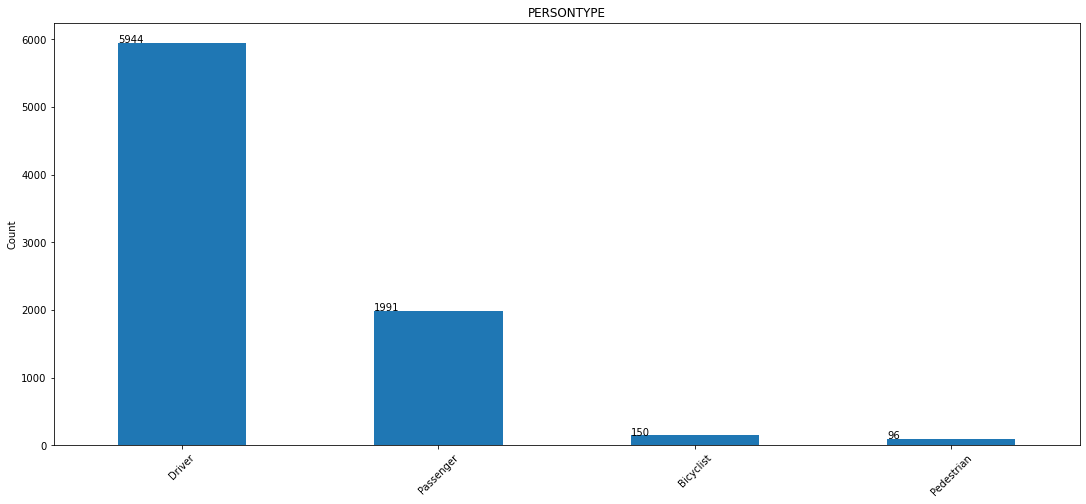

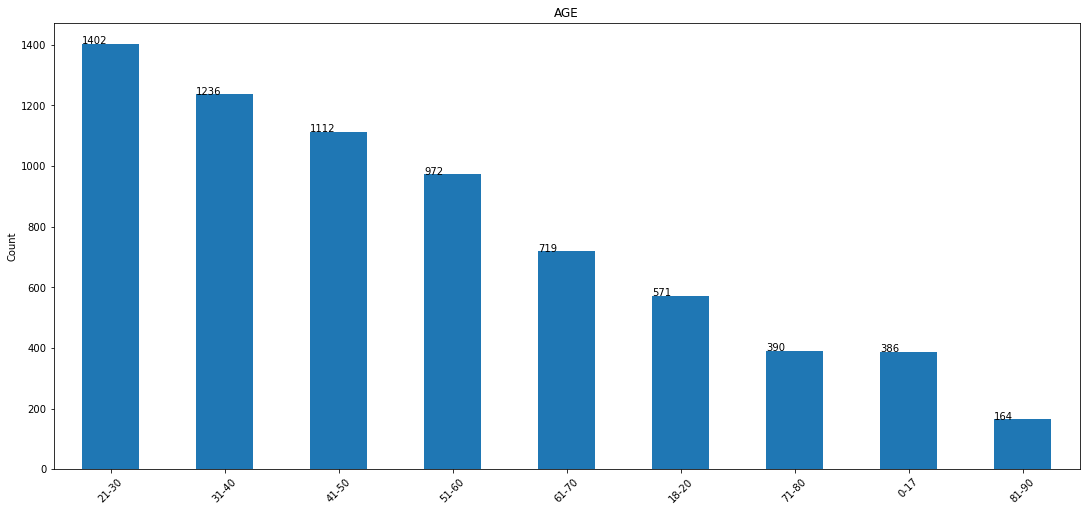

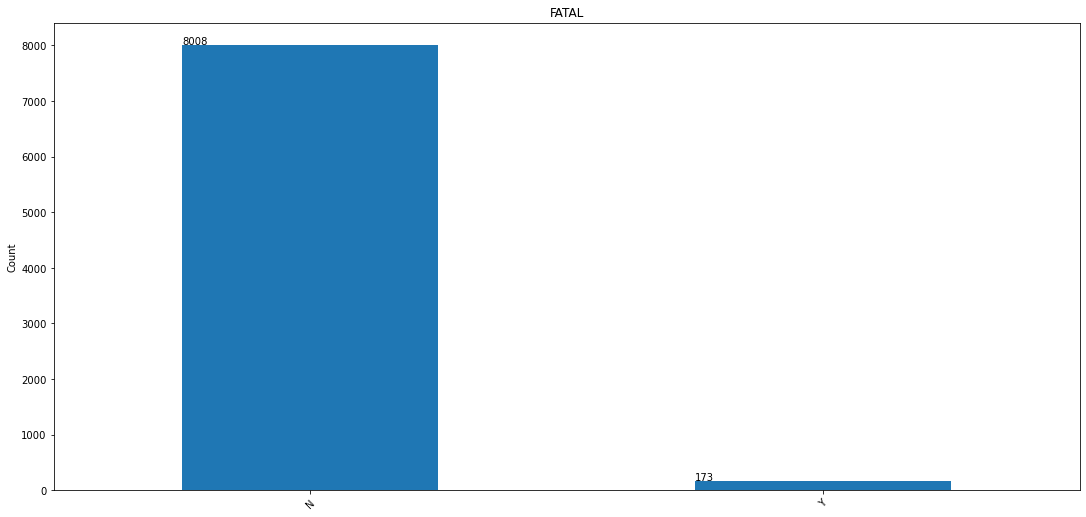

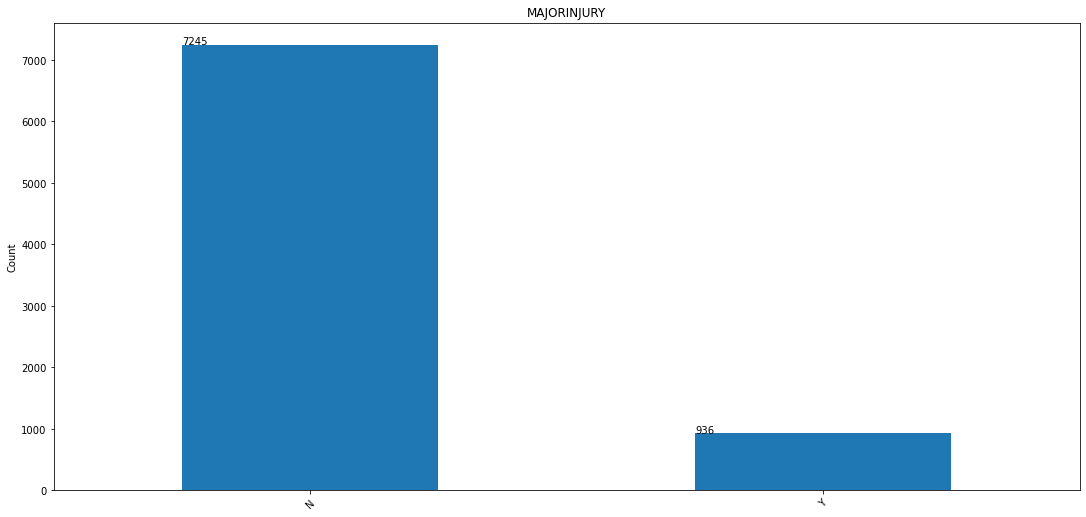

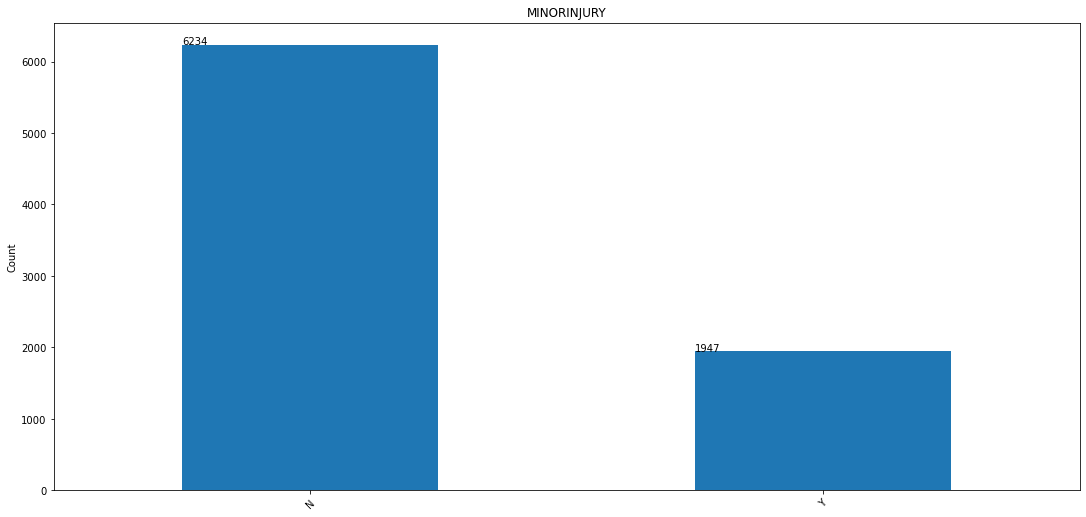

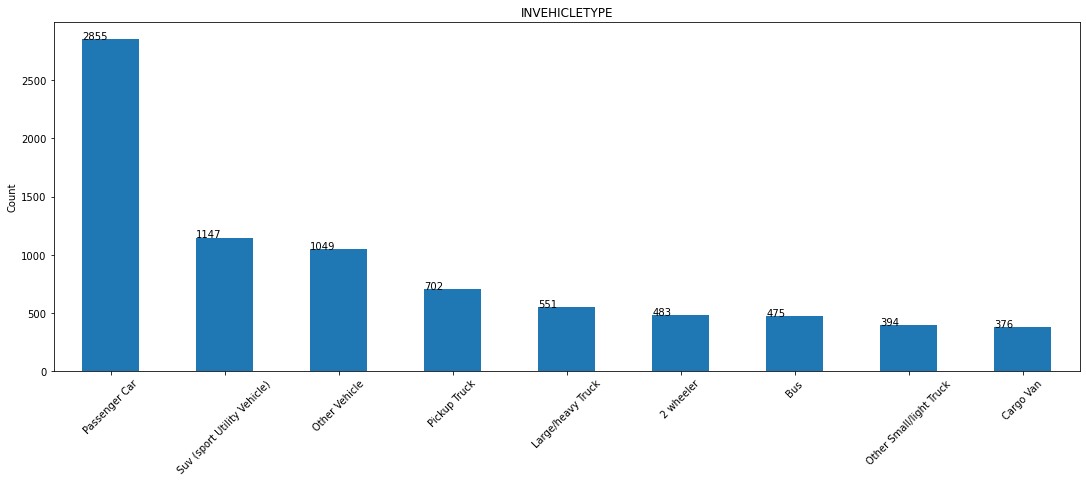

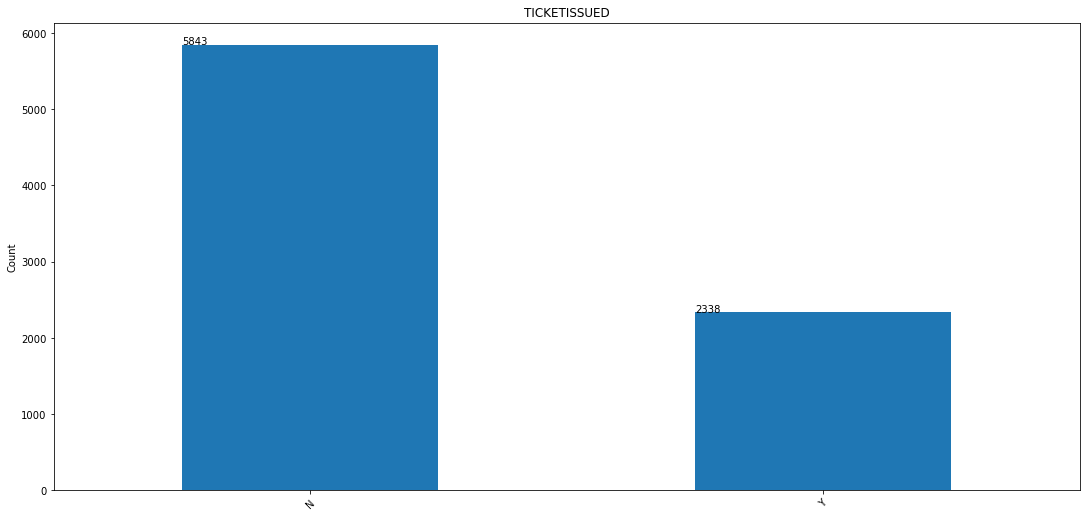

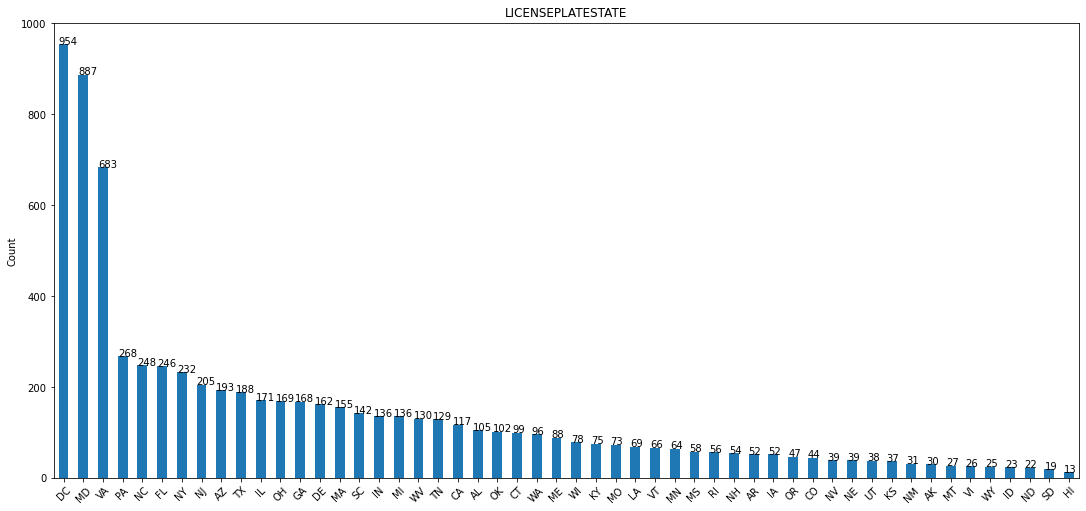

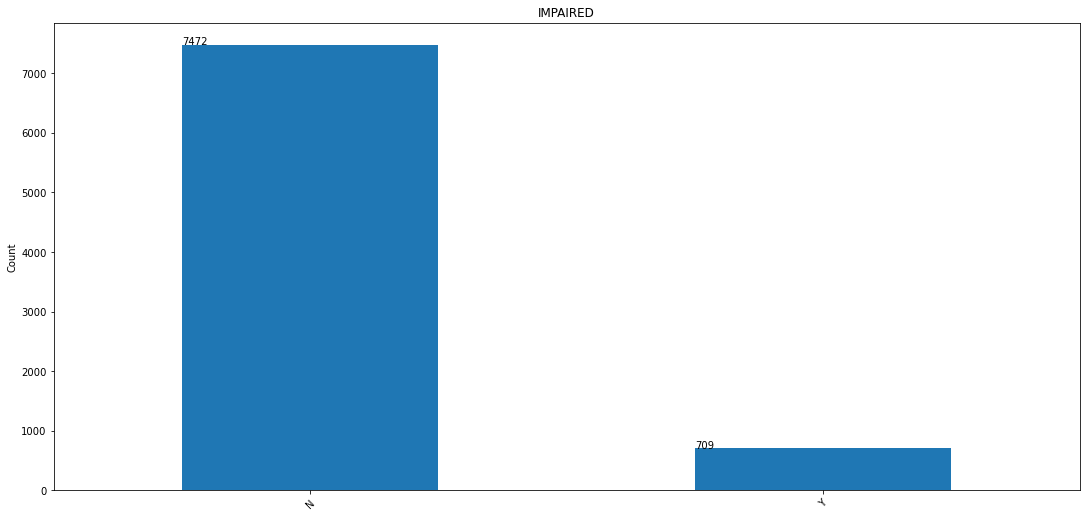

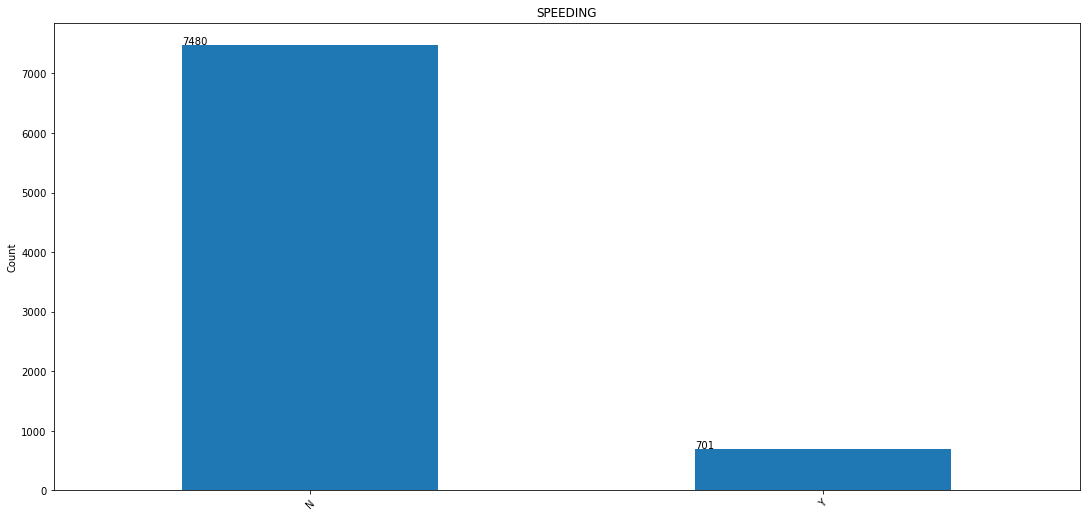

In [38]:
# plot distribution of each column including target column
for col in raw.columns:
    
    plt.figure(figsize=(15,7))
    # https://stackoverflow.com/a/51676757
    ax = raw[col].value_counts().plot(kind="bar")
    for p in ax.patches:
        ax.annotate('{}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
    plt.tight_layout()
    plt.title(col)
    # https://www.datasciencelearner.com/matplotlib-rotate-x-axis-labels/
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

# Stratified Split Based on FATAL Column

In [39]:
# convert FATAL column to numeric
raw["FATAL"] = raw["FATAL"].replace({"Y":1, "N":0})

In [40]:
# Divide all data into 60-40 split
df_train, df_test = data_splitter(raw, 0.6, stratification_column="FATAL", seed=42)

In [41]:
# Divide test data into 50-50 split
df_val, df_test = data_splitter(df_test, 0.5, stratification_column="FATAL", seed=42)

# Handling missing data

In [42]:
nan_checker(df_train)

,var,proportion,dtype
0,AGE,0.154442,object
1,LICENSEPLATESTATE,0.096577,object
2,INVEHICLETYPE,0.017319,object


In [43]:
nan_checker(df_val)

,var,proportion,dtype
0,AGE,0.138142,object
1,LICENSEPLATESTATE,0.102689,object
2,INVEHICLETYPE,0.018337,object


In [44]:
nan_checker(df_test)

,var,proportion,dtype
0,AGE,0.149664,object
1,LICENSEPLATESTATE,0.105681,object
2,INVEHICLETYPE,0.020770,object


Impute missing data for train using train statistics and impute missing data in test using test statistics!

In [45]:
df_train, df_val, df_test = impute_data(["AGE", "LICENSEPLATESTATE", "INVEHICLETYPE"], df_train, df_val, df_test, "most_frequent")

In [46]:
nan_checker(df_train)

,var,proportion,dtype


In [47]:
nan_checker(df_val)

,var,proportion,dtype


In [48]:
nan_checker(df_test)

,var,proportion,dtype


# Encode Categorical Data

In [49]:
raw.dtypes

PERSONTYPE           object
AGE                  object
FATAL                 int64
MAJORINJURY          object
MINORINJURY          object
INVEHICLETYPE        object
TICKETISSUED         object
LICENSEPLATESTATE    object
IMPAIRED             object
SPEEDING             object
dtype: object

All columns are categorical, we one hot encode the data.

In [50]:
len(df_train)

4908

In [51]:
len(df_val)

1636

In [52]:
len(df_test)

1637

In [53]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [54]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=["PERSONTYPE", "AGE", "INVEHICLETYPE", "LICENSEPLATESTATE", "MAJORINJURY", "MINORINJURY", "TICKETISSUED", "IMPAIRED", "SPEEDING"])

# Print the first 5 rows of df
df.head()

,FATAL,PERSONTYPE_Bicyclist,PERSONTYPE_Driver,PERSONTYPE_Passenger,PERSONTYPE_Pedestrian,AGE_0-17,AGE_18-20,AGE_21-30,AGE_31-40,AGE_41-50,...,MAJORINJURY_N,MAJORINJURY_Y,MINORINJURY_N,MINORINJURY_Y,TICKETISSUED_N,TICKETISSUED_Y,IMPAIRED_N,IMPAIRED_Y,SPEEDING_N,SPEEDING_Y
0,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,0,1,1,0,1,0
1,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,1,1,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
3,0,0,0,1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
4,0,0,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0


In [55]:
# Separating the training, validation and test data

# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [56]:
len(df_train)

4908

In [57]:
len(df_val)

1636

In [58]:
len(df_test)

1637

In [59]:
(df_train["FATAL"].value_counts()/len(df_train))*100

0    97.881011
1     2.118989
Name: FATAL, dtype: float64

In [60]:
(df_val["FATAL"].value_counts()/len(df_val))*100

0    97.92176
1     2.07824
Name: FATAL, dtype: float64

In [61]:
(df_test["FATAL"].value_counts()/len(df_test))*100

0    97.861943
1     2.138057
Name: FATAL, dtype: float64

### Save train and test data as csv files

In [62]:
df_train.to_csv("input_data/train.csv", index=False)
df_val.to_csv("input_data/validation.csv", index=False)
df_test.to_csv("input_data/test.csv", index=False)

--------------------

### Separate the feature and Target columns

In [63]:
X_train, y_train = df_train[np.setdiff1d(df_train.columns, "FATAL")].values, df_train["FATAL"].values

In [64]:
print(X_train)
print()
print(y_train)

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]

[0 0 0 ... 0 0 0]


In [65]:
X_val, y_val = df_val[np.setdiff1d(df_val.columns, "FATAL")].values, df_val["FATAL"].values

In [66]:
print(X_val)
print()
print(y_val)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 1 0]]

[0 0 0 ... 0 0 0]


In [67]:
X_test, y_test = df_test[np.setdiff1d(df_test.columns, "FATAL")].values, df_test["FATAL"].values

In [68]:
print(X_test)
print()
print(y_test)

[[0 0 1 ... 1 1 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]]

[0 0 0 ... 0 0 0]


### Pickle X_train, y_train, X_val, y_val, X_test, y_test

In [69]:
save_object("./input_data/", "X_train", X_train)
save_object("./input_data/", "y_train", y_train)
save_object("./input_data/", "X_val", X_val)
save_object("./input_data/", "y_val", y_val)
save_object("./input_data/", "X_test", X_test)
save_object("./input_data/", "y_test", y_test)